# Weekly assignment 3

## Read before you start

* Provide clear and complete answers in code blocks or markdown. You may add as many as you need.
* Always motivate your answers. This can be done in markdown cells, or in comments in code.
* Submit your results via Brightspace. Use the following filename convention: ``StudentName1_snumber1_StudentName2_snumber2_Assignment3.ipynb``.
* Make sure you submit a fully executed version of the notebook file. The teaching assistants will not run/debug your code during grading.
* Questions? Ask them during the workgroups, or see Brightspace for instructions on how to proceed.

## (Approximate) inference

As always, consider Bayes' theorem:

$
p(\theta \mid D) = \frac{ p(D\mid \theta)p(\theta) }{ p(D) } = \frac{ p(D\mid \theta)p(\theta) }{ \int_{\theta'} p(D\mid \theta')p(\theta') \, \mathrm{d}\theta' }
$

For conjugate pairs of prior and posterior this is straightforward, as we saw last week. For example, if we use a binomial likelihood, so:

$
p(D\mid \theta) = \mathrm{Binomial}(z \mid N, \theta) = \binom{N}{z}\theta^{z}(1-\theta)^{N-z}\enspace,
$

together with a beta prior:

$
p(\theta) = \mathrm{beta}(\theta\mid a, b) = \frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)} \enspace,
$

then our posterior will also be a beta distribution:

$
p(\theta \mid D) = p(\theta \mid z, N, a, b) = \mathrm{beta}(\theta \mid z+a, N-z+b) \enspace.
$

Easy peasy!

However, in practice we often use combinations of likelihood and prior that are not conjugate. In that case, the integral $\int_{\theta'} p(D\mid \theta')p(\theta') \,\mathrm{d}\theta'$ is difficult (or even impossible) to solve. This forces us to move away from _exact_ inference to _approximate_ inference.

In this week's exercise we will implement a common and effective approximate inference strategy: **Markov chain Monte Carlo**. You already heard the basic ideas in the lecture, but now you'll make your own MCMC sampler!

To verify whether the approximation is correct, we will first use it to infer the posterior distribution for the binomial likelihood and beta prior. We don't _need_ approximations here, as that combination is conjugate, but it allows us to check whether our approach is correct.

Let's pick some arbitrary values to define our observations and prior beliefs. Let $z=17$, $N=28$, and $a=3$, $b=7$.

### Exact inference, for comparison

1. Just as last week, make a figure consisting of three subplots. Show in the first plot the prior distribution, in the second the likelihood, and in the third the (exact) posterior. **The posterior in your last subplot is what we will try to approximate next!**


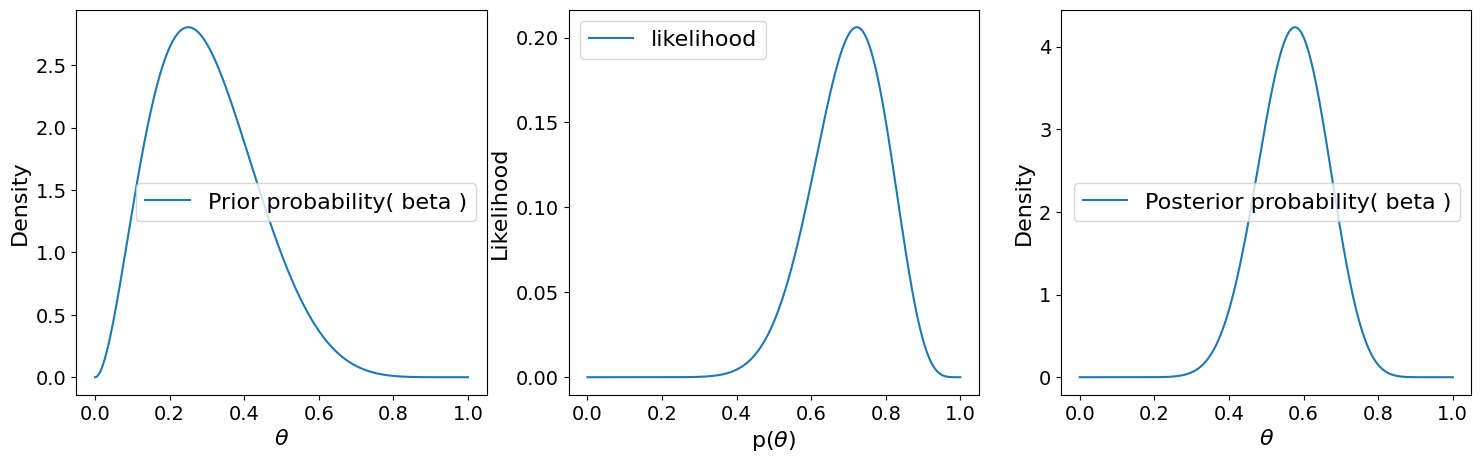

In [1]:
import numpy as np
import scipy.stats
from scipy.stats import binom, beta, mode, norm
import matplotlib.pyplot as plt
plt.rc('font', size=14)         # default fontsize
plt.rc('axes', titlesize=16)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=16)   # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
plt.rc('figure', titlesize=16)  # fontsize of the figure title

#Observed data
z, n = 13, 18

#beta distribution
a, b = 3, 7

# to code
#Theta, so we define values [0:1]:
theta_values = np.linspace(0,1,1000)

prior_pdf = beta.pdf(theta_values, a, b)

posterior_pdf = beta.pdf(theta_values, a + z, b + n - z)

max_posterior_idx = np.argmax(posterior_pdf)
mode_value = theta_values[max_posterior_idx]

likelihood = binom.pmf(z, n, theta_values)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharex=True)

# Plot prior
axes[0].plot(theta_values, prior_pdf, label = 'Prior probability( beta )')
axes[0].set_xlabel('$\\theta$')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot likelihood
axes[1].plot(theta_values, likelihood, label = 'likelihood')

axes[1].set_xlabel('p($\\theta$)')
axes[1].set_ylabel('Likelihood')
axes[1].legend()

# Plot posterior
axes[2].plot(theta_values, posterior_pdf, label = 'Posterior probability( beta )')
axes[2].set_xlabel('$\\theta$')
axes[2].set_ylabel('Density')
axes[2].legend()






### Markov chain Monte Carlo

Many different Markov chain Monte Carlo (MCMC) algorithms exist. They are all based on the same idea: by drawing random numbers in a clever way, we obtain a collection of _samples_. The distribution of these samples approximates the distribution we are looking for. The more samples we collect, the better our approximation.

Here is the outline for the algorithm we implement here, Metropolis MCMC:

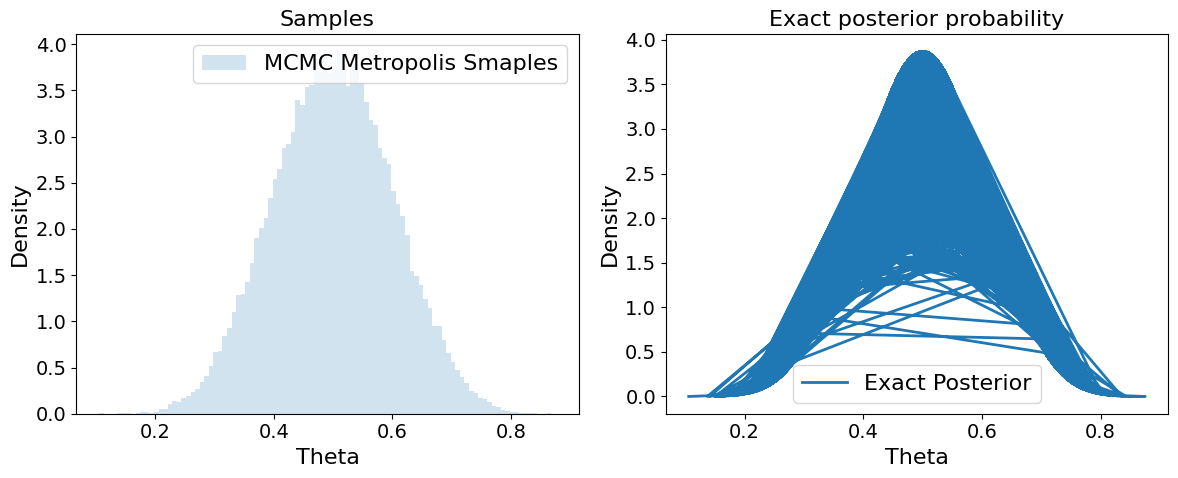

In [11]:
import numpy as np
import scipy.stats
from typing import Union

z = 10
n = 20
a = 2
b = 2

def likelihood_fn(theta, z: int, N: int):
    return scipy.stats.binom.pmf(z, N, theta)

def prior_fn(theta, a: Union[int, float], b: Union[int, float]):
    return scipy.stats.beta.pdf(theta, a, b)

def proposal_distribution(theta_current: float, step: float):
    new_theta = scipy.stats.norm.rvs(theta_current, step)
    # Ensure new_theta stays within [0, 1]
    new_theta = np.clip(new_theta, 0, 1)
    return new_theta

def compute_acceptance_ratio(theta_proposal: float, theta_current: float):
    likelihood_ratio = likelihood_fn(theta_proposal, z, n) / likelihood_fn(theta_current, z, n)
    prior_ratio = prior_fn(theta_proposal, a, b) / prior_fn(theta_current, a, b)
    return likelihood_ratio * prior_ratio

M = 100_000  # number of samples
stepsize = 0.1  # Step size for the proposal distribution

theta_samples = np.zeros((M,))
theta_samples[0] = np.random.uniform(0, 1)

for i in range(1, M):
    theta_current = theta_samples[i-1]
    theta_proposal = proposal_distribution(theta_current, stepsize)

    acceptance_ratio = compute_acceptance_ratio(theta_proposal, theta_current)
    acceptance_ratio = np.min([1.0, acceptance_ratio])

    if np.random.uniform() < acceptance_ratio:
        theta_samples[i] = theta_proposal
    else:
        theta_samples[i] = theta_current

# Posterior vs Histogram
posterior_pdf = scipy.stats.beta.pdf(theta_samples, a + z, b + n - z)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axes[0].hist(theta_samples, bins=100, density=True, alpha=0.2, label='MCMC Metropolis Smaples')
axes[0].set_xlabel('Theta')
axes[0].set_ylabel('Density')
axes[0].set_title('Samples')
axes[0].legend()

axes[1].plot(theta_samples, posterior_pdf, label='Exact Posterior', linewidth=2)
axes[1].set_xlabel('Theta')
axes[1].set_ylabel('Density')
axes[1].set_title('Exact posterior probability')
axes[1].legend()

plt.tight_layout()
plt.show()

As you can see, there are several crucial details missing for this algorithm, and your task is to fill these in.

2. First, complete the functions ``likelihood_fn`` (this is $p(z \mid \theta, N)$, for which we used the binomial distribution; see above) and ``prior_fn`` (this is $p(\theta \mid a, b)$, the beta distribution; see above). Of course, you already have code for this, you used it in question 1.

3. The **proposal distribution** $q(\theta' \mid \theta)$ determines which value we consider next. Importantly, it depends on our _current_ value (hence we call this a 'Markov chain'). Often, we use a symmetric distribution (so that $q(\theta' \mid \theta) = q(\theta \mid \theta')$), like the Gaussian distribution. Implement $q(\theta \mid \theta) = N(\theta, \sigma^2)$ using `scipy.stats.norm.rvs()`. This function has two parameters: `loc` is its mean (for which we use the _current value_ of $\theta$) and `scale`, which is the standard deviation $\sigma$. This determines how big the steps are that we take. It is a parameter that we can set for ourselves. To start, set it to $\sigma=0.1$.

4. Now comes the crucial computation: the acceptance ratio:
$$\alpha = \frac{p(z \mid \theta', N)p(\theta' \mid a, b)}{p(z \mid \theta, N)p(\theta \mid a, b)}$$

  Implement this function in the algorithm. You will need to use your earlier `likelihood_fn` and `prior_fn` here. Note: If you write out the likelihood and prior in the equation for the acceptance ratio, you'll see that constant terms (terms that do not depend on $\theta$) appear in both the enumerator and the denominator. That means that for _this purpose_, you can safely omit them. For difficult distributions with complication normalization terms, that can make the MCMC algorithm a lot faster, although for this example the difference is small.

5. Determine what to do once the proposal is accepted or rejected. If the proposal is accepted, the new value should be stored. If the proposal is rejected, the old value should be stored once more.

6. Lastly, we have to determine the initial value: where does our Markov chain start? This must be an appropriate value for $\theta$, so a number between 0 and 1 in this case (since $\theta$ is a coin flip probability). Set your first sample, `theta_samples[0]` to a random value between 0 and 1.

7. Now your algorithm should be ready to run. Collect $M=100\,000$ samples and make a new figure: In this figure, show the exact posterior you computed in question 1, and a histogram of the collected samples (use `plt.hist(..., density=True)` to have Python show the density of the samples instead of the counts). Are they showing the same shape? (If they don't, you made a mistake!)



You have now constructed your first approximate inference algorithm! Note that, aside from numerical issues, the same approach will work for many different problems. All that needs to change are the likelihood and prior functions.

8. Using your MCMC approximation, what is the probability that $\theta \in [0.5, 0.7]$?

In [12]:
theta_of_interest = theta_samples[(theta_samples >= 0.5) & (theta_samples <= 0.7)]    # I assume you include if the squre brackets

# Using the empirical probability formula
p_of_interest = len(theta_of_interest) / len(theta_samples)
print(p_of_interest)

0.47941


The above example was a bit superfluous; after all the prior was nicely conjugate so we could compute the exact posterior. However, that is no longer the case for the 'weird' prior that was discussed in the lecture:

$$ p(\theta) = \frac{2}{3} \left( \cos (4\pi \theta) + 1\right)^2 $$

8. Copy-paste your MCMC algorithm into a new notebook cell and replace the `prior_fn` by the 'weird' prior. Run your algorithm and once more plot the histogram of the samples. Note: this time we don't have an exact solution to compare to, because this is not computable! Without MCMC (or other approximations), we would not be able to compute Bayes' theorem in this case!

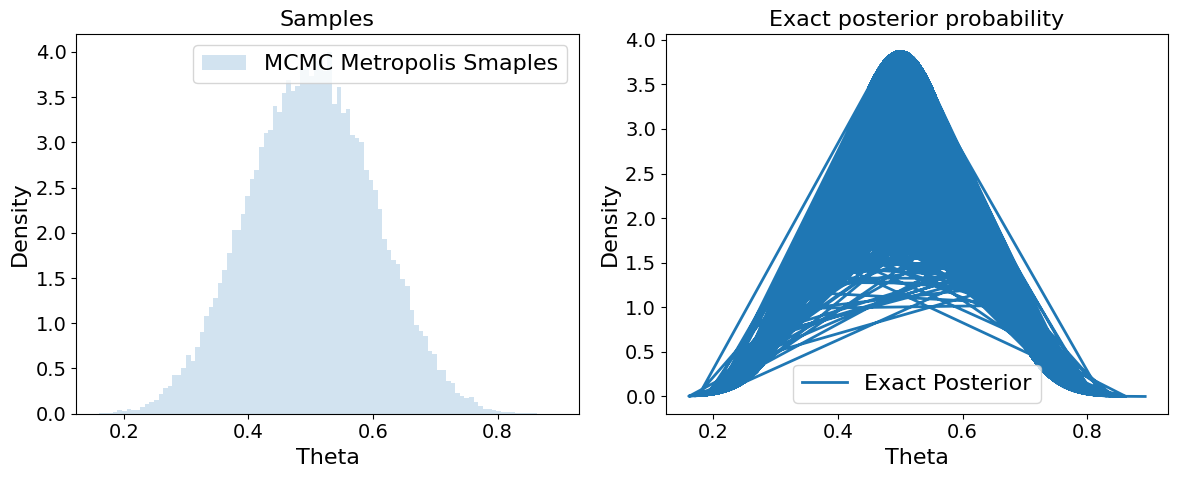

In [13]:
import numpy as np
import scipy.stats

z = 10
n = 20
a = 2
b = 2

def likelihood_fn(theta, z: int, N: int):
    return scipy.stats.binom.pmf(z, N, theta)

def weird_prior_fn(theta):
    return (2/3)*(np.cos(4 * np.pi * theta) + 1)**2

def proposal_distribution(theta_current: float, step: float):
    new_theta = scipy.stats.norm.rvs(theta_current, step)
    new_theta = np.clip(new_theta, 0, 1)
    return new_theta

def compute_acceptance_ratio(theta_proposal: float, theta_current: float):
    likelihood_ratio = likelihood_fn(theta_proposal, z, n) / likelihood_fn(theta_current, z, n)
    prior_ratio = prior_fn(theta_proposal, a, b) / prior_fn(theta_current, a, b)
    return likelihood_ratio * prior_ratio

M = 100_000  # number of samples
stepsize = 0.1  # Step size for the proposal distribution

theta_samples = np.zeros((M,))
theta_samples[0] = np.random.uniform(0, 1)

for i in range(1, M):
    theta_current = theta_samples[i-1]
    theta_proposal = proposal_distribution(theta_current, stepsize)

    acceptance_ratio = compute_acceptance_ratio(theta_proposal, theta_current)
    acceptance_ratio = np.min([1.0, acceptance_ratio])

    if np.random.uniform() < acceptance_ratio:
        theta_samples[i] = theta_proposal
    else:
        theta_samples[i] = theta_current

# Posterior vs Histogram
posterior_pdf = scipy.stats.beta.pdf(theta_samples, a + z, b + n - z)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axes[0].hist(theta_samples, bins=100, density=True, alpha=0.2, label='MCMC Metropolis Smaples')
axes[0].set_xlabel('Theta')
axes[0].set_ylabel('Density')
axes[0].set_title('Samples')
axes[0].legend()

axes[1].plot(theta_samples, posterior_pdf, label='Exact Posterior', linewidth=2)
axes[1].set_xlabel('Theta')
axes[1].set_ylabel('Density')
axes[1].set_title('Exact posterior probability')
axes[1].legend()

plt.tight_layout()
plt.show()

As you have probably already noticed, the weird prior has multiple 'bumps'. Since the posterior combines the likelihood and the prior, these bumps are also present in the posterior. In theory, this is no problem for MCMC: it will explore one bump, and at some point a sequence of random steps will bring it to another bump to explore. The amount of time spend in each bump is exactly consistent with their relative probabilities, so all is fine. However, these guarantees only hold for $M\rightarrow \infty$, and 'nobody got time for that'. To show what can go wrong with MCMC, run your algorithm again, but now decrease the stepsize, by setting $\sigma=0.01$.

9. Make another figure of the posterior histogram, but make sure the stepsize is small enough so that the posterior shows only _one_ bump instead of two. Also draw a vertical line with `plt.axvline(...)`at the location of your initial position, that is, `theta_samples[0]`. Explain how, __without knowing the true posterior__ we could at least identify that this problem occurs (see slides).

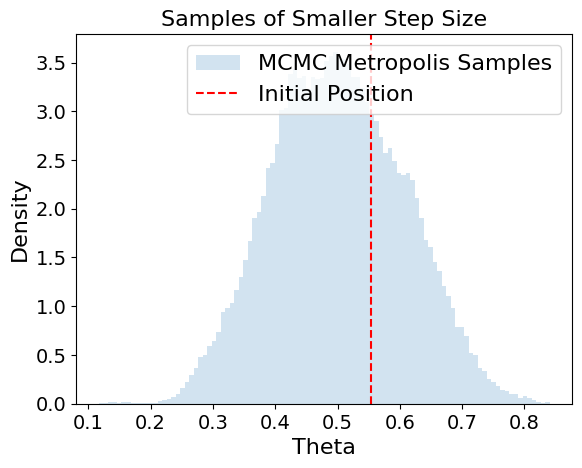

In [17]:
import numpy as np
import scipy.stats

z = 10
n = 20
a = 2
b = 2

def likelihood_fn(theta, z: int, N: int):
    return scipy.stats.binom.pmf(z, N, theta)

def weird_prior_fn(theta):
    return (2/3)*(np.cos(4 * np.pi * theta) + 1)**2

def proposal_distribution(theta_current: float, step: float):
    new_theta = scipy.stats.norm.rvs(theta_current, step)
    new_theta = np.clip(new_theta, 0, 1)
    return new_theta

def compute_acceptance_ratio(theta_proposal: float, theta_current: float):
    likelihood_ratio = likelihood_fn(theta_proposal, z, n) / likelihood_fn(theta_current, z, n)
    prior_ratio = prior_fn(theta_proposal, a, b) / prior_fn(theta_current, a, b)
    return likelihood_ratio * prior_ratio

M = 100_000  # number of samples
stepsize = 0.01  # COrrected Step size for the proposal distribution

theta_samples = np.zeros((M,))
theta_samples[0] = np.random.uniform(0, 1)

for i in range(1, M):
    theta_current = theta_samples[i-1]
    theta_proposal = proposal_distribution(theta_current, stepsize)

    acceptance_ratio = compute_acceptance_ratio(theta_proposal, theta_current)
    acceptance_ratio = np.min([1.0, acceptance_ratio])

    if np.random.uniform() < acceptance_ratio:
        theta_samples[i] = theta_proposal
    else:
        theta_samples[i] = theta_current

# Posterior vs Histogram
plt.hist(theta_samples, bins=100, density=True, alpha=0.2, label='MCMC Metropolis Samples')
plt.axvline(x=theta_samples[0], color='red', linestyle='--', label='Initial Position')
plt.xlabel('Theta')
plt.ylabel('Density')
plt.title('Samples of Smaller Step Size')
plt.legend()
plt.show()